In [2]:
!pip install transformers langdetect spacy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,precision_score, recall_score
import nltk
import re
import spacy
from nltk.tokenize import word_tokenize
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F
import time 
import datetime
import tensorflow as tf
import sys
import os
import warnings

sp = spacy.load('en_core_web_sm')
nltk.download('punkt')
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#ffb6c1','#add8e6','#98fb98','#fffacd','#dcb4e4','#ffdab9']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 10,5
seed=42
np.random.seed(seed)
torch.manual_seed(seed)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [104]:
df_review = pd.read_json("C:/Users/USER/Downloads/yelp_dataset/yelp_academic_dataset_review.json", nrows=10000, lines=True)

In [105]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [106]:
len(df_review)

10000

In [107]:
cols_to_drop = ['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'] 
df_review.drop(cols_to_drop, axis=1, inplace=True)

In [108]:
df_review.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...


In [109]:
df_business = pd.read_json("C:/Users/USER/Downloads/yelp_dataset/yelp_academic_dataset_business.json", nrows=10000, lines=True)

In [110]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [111]:
df_business = df_business[df_business['categories'].notnull()]
df_business_new = df_business[df_business['categories'].str.contains('Restaurant')]

df_business_new =  df_business_new[['business_id', 'categories']]


In [112]:
df_business_new.head()

,business_id,categories
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
8,k0hlBqXX-Bt0vf1op7Jr1w,"Pubs, Restaurants, Italian, Bars, American (Tr..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
11,eEOYSgkmpB90uNA7lDOMRA,"Vietnamese, Food, Restaurants, Food Trucks"


In [115]:
df_joined = df_review.merge(df_business_new, how='inner', on='business_id')

In [116]:
df_joined.head()

,business_id,stars,text,categories
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...","Restaurants, Breakfast & Brunch, Food, Juice B..."
1,XQfwVwDr-v0ZS3_CbbE5Xw,2,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
2,XQfwVwDr-v0ZS3_CbbE5Xw,4,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
3,XQfwVwDr-v0ZS3_CbbE5Xw,3,We came on a Saturday morning after waiting a ...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
4,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian"


In [117]:
# Rename and drop columns
df_joined.rename(columns={'text':'restaurant_reviews'}, inplace=True)
df_joined.drop('business_id', axis=1, inplace=True)


In [118]:
# Analyze only English reviews
from langdetect import detect

df_joined['detect'] = df_joined['restaurant_reviews'].apply(detect)
df_joined = df_joined[df_joined['detect'] == 'en'].reset_index(drop=True)


In [119]:
# Check for NaN values
df_joined.isnull().values.any()

# Remove duplicate rows
df_joined.drop_duplicates(inplace=True)

# Remove 3-star reviews
df_joined = df_joined[df_joined['stars'] != 3]

In [120]:
df_joined.head()

,stars,restaurant_reviews,categories,detect
1,2,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
2,4,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
4,5,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en
5,2,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en
6,5,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en


In [121]:
len(df_joined)

4228

In [122]:
# Label reviews as positive or negative
df_joined.loc[df_joined['stars'] < 3, 'sentiment'] = 0 # negative lable given to rating lower than 3 stars
df_joined.loc[df_joined['stars'] > 3, 'sentiment'] = 1 # positive label given to ratings higher than 3 stars
df_joined.drop('stars', axis=1, inplace=True)

In [123]:
df_joined.head()

,restaurant_reviews,categories,detect,sentiment
1,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,0.0
2,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,1.0
4,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en,1.0
5,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en,0.0
6,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en,1.0


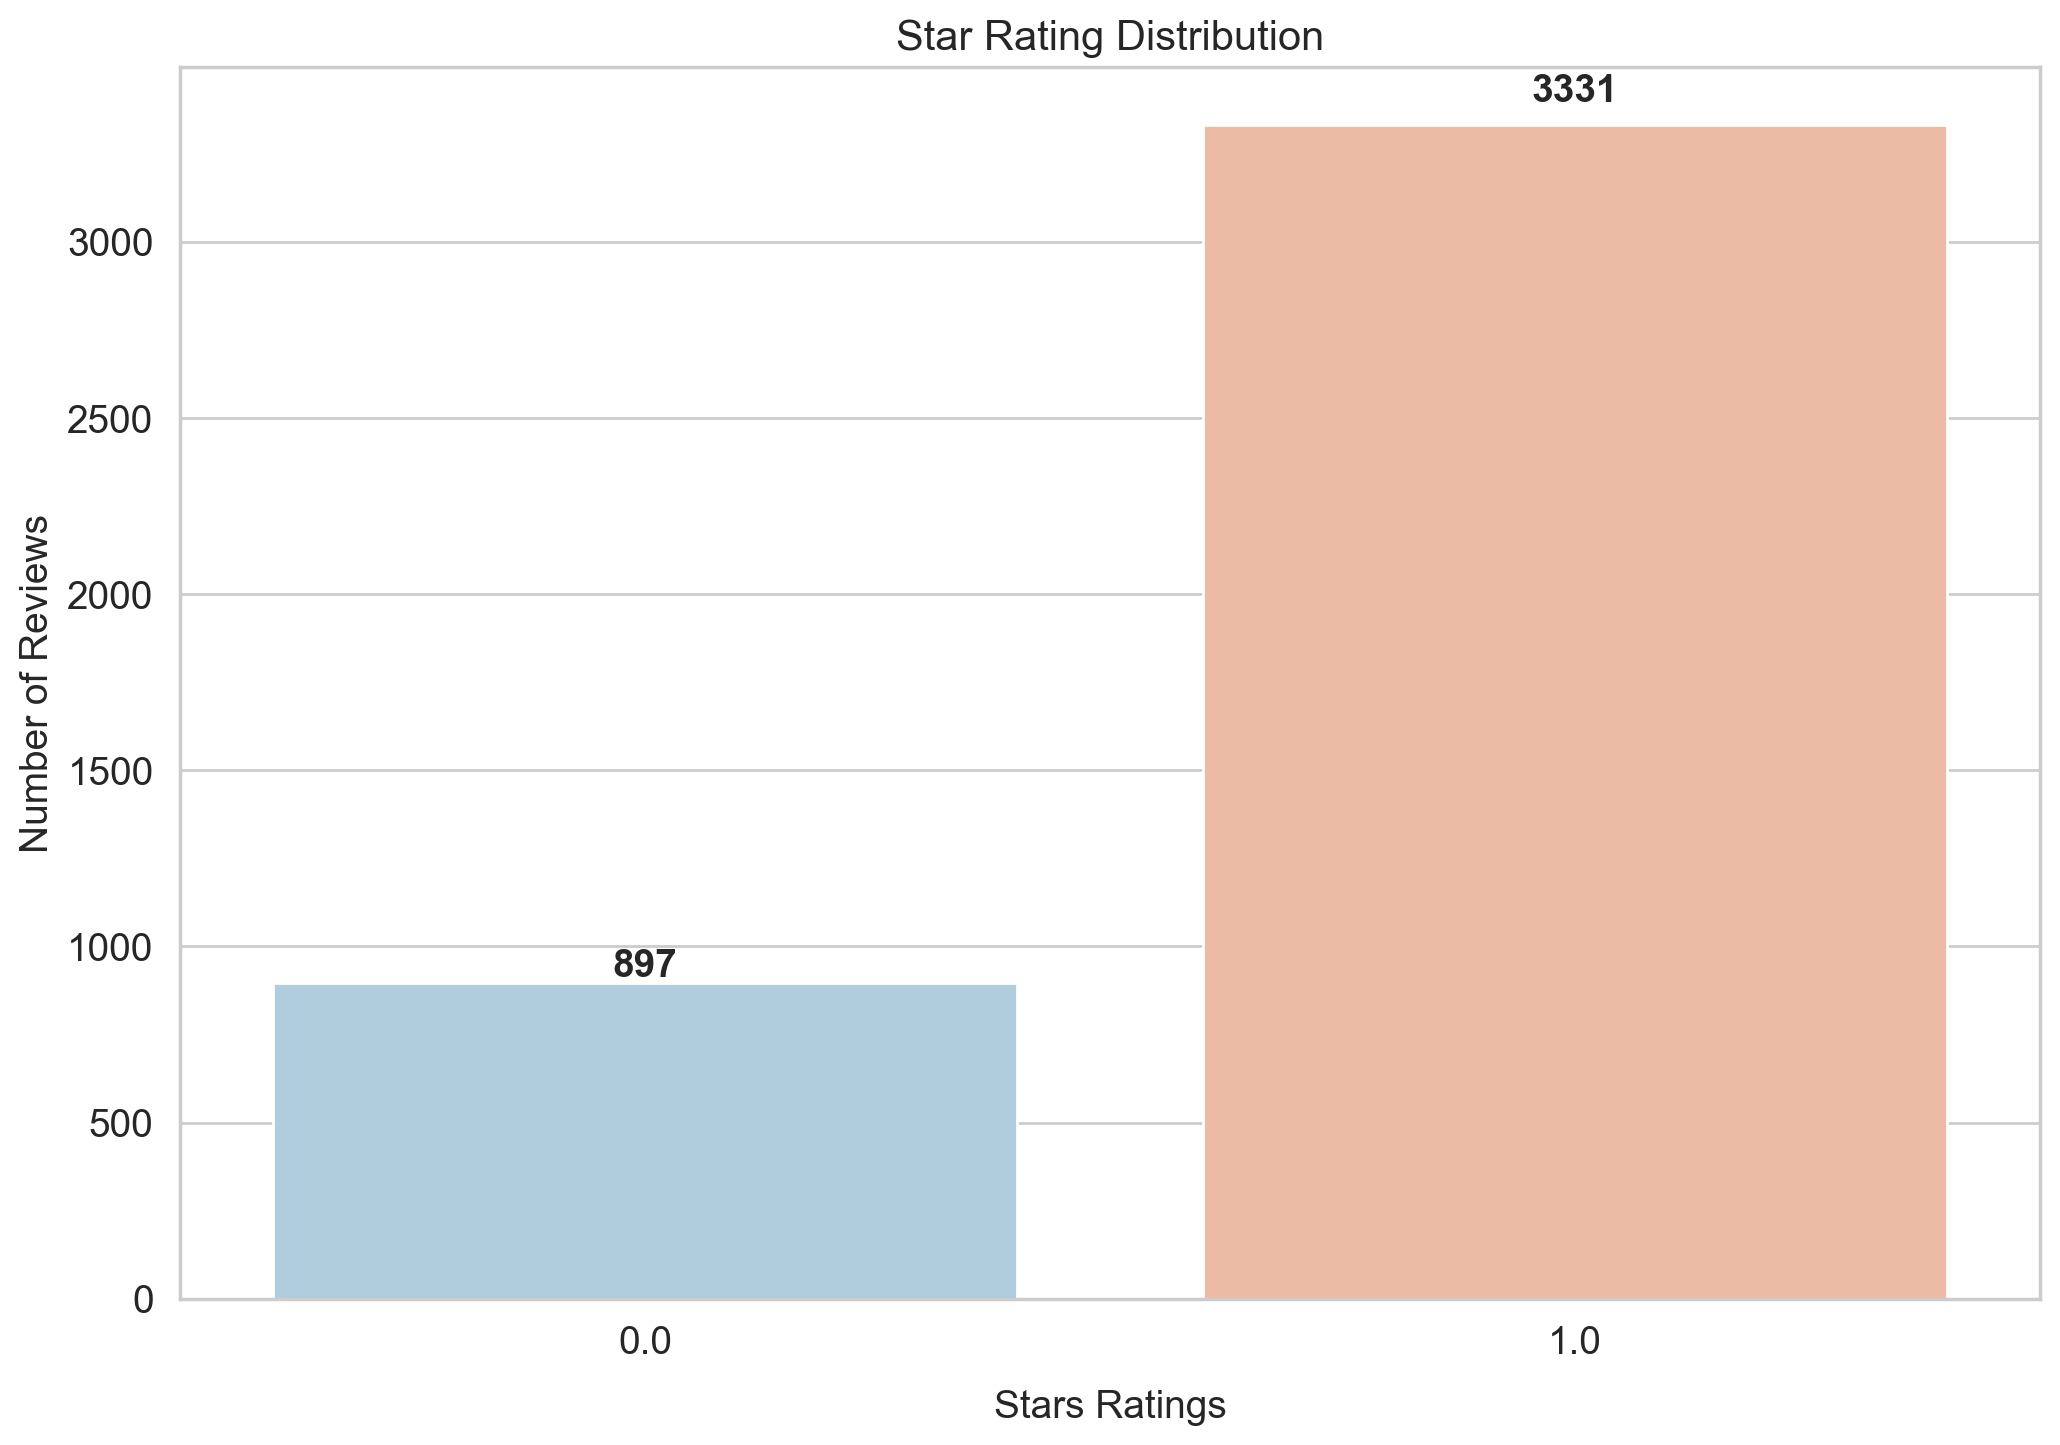

In [124]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,8))
grouped = df_joined.sentiment.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Stars Ratings', labelpad=10, fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Star Rating Distribution', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)


In [125]:
from sklearn.utils import resample

df_more = df_joined[(df_joined['sentiment']==1)] 
df_less = df_joined[(df_joined['sentiment']==0)] 


df_less_resampled = resample(df_less, 
                                 replace=True,   
                                 n_samples= len(df_more), # to match majority class
                                 random_state=42)  
df_clean = pd.concat([df_less_resampled, df_more])

df_clean.sentiment.value_counts()

sentiment
0.0    3331
1.0    3331
Name: count, dtype: int64

In [126]:
# Remove spaCy stopwords
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words
exclude_stopwords = ['no', 'not']
for word in exclude_stopwords:
    stopwords.remove(word)

KeyError: 'no'

In [ ]:
# Define text preprocessing function
# The input is a single string (a raw restaurant review), and the output is a single string (a preprocessed restaurant review)

def text_preprocessing( raw_review ):
    # 1. Remove non-letters 
    review_text_letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # 2. Convert to lower case
    review_preprocessed = review_text_letters_only.lower()
    # 3. Word tokenization
    review_tokens = word_tokenize(review_preprocessed)
    # 4. Filter the stopwords
    filtered_sentence =[] 
    for word in review_tokens:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    return " ".join(filtered_sentence)

In [32]:
# Apply text preprocessing to create cleaned_reviews column
df_clean['cleaned_reviews'] = df_clean['restaurant_reviews'].apply(text_preprocessing) 
df = df_clean.reset_index(drop=True)

In [127]:
df.head()

,restaurant_reviews,categories,detect,sentiment,cleaned_reviews
0,Wow have things changed at this location. I us...,"Vegetarian, American (New), Mediterranean, San...",en,0.0,wow things changed location come regular basis...
1,The service was great and the restaurant was c...,"Restaurants, Italian, Pizza",en,0.0,service great restaurant clean food okay lingu...
2,"Decent, quick serve food. Certainly not gourme...","Mexican, Tacos, Restaurants, Tex-Mex, Fast Foo...",en,0.0,decent quick serve food certainly gourmet taco...
3,Please be careful when you order food to go f...,"Restaurants, American (New), Southern, Chinese",en,0.0,careful order food restaurant website updated ...
4,i wish i could have given it a zero or a negat...,"Vegetarian, American (New), Mediterranean, San...",en,0.0,wish given zero negative experience pleasant o...


In [128]:
pre_trained_model='bert-base-uncased'
tokenizer=BertTokenizer.from_pretrained(pre_trained_model)

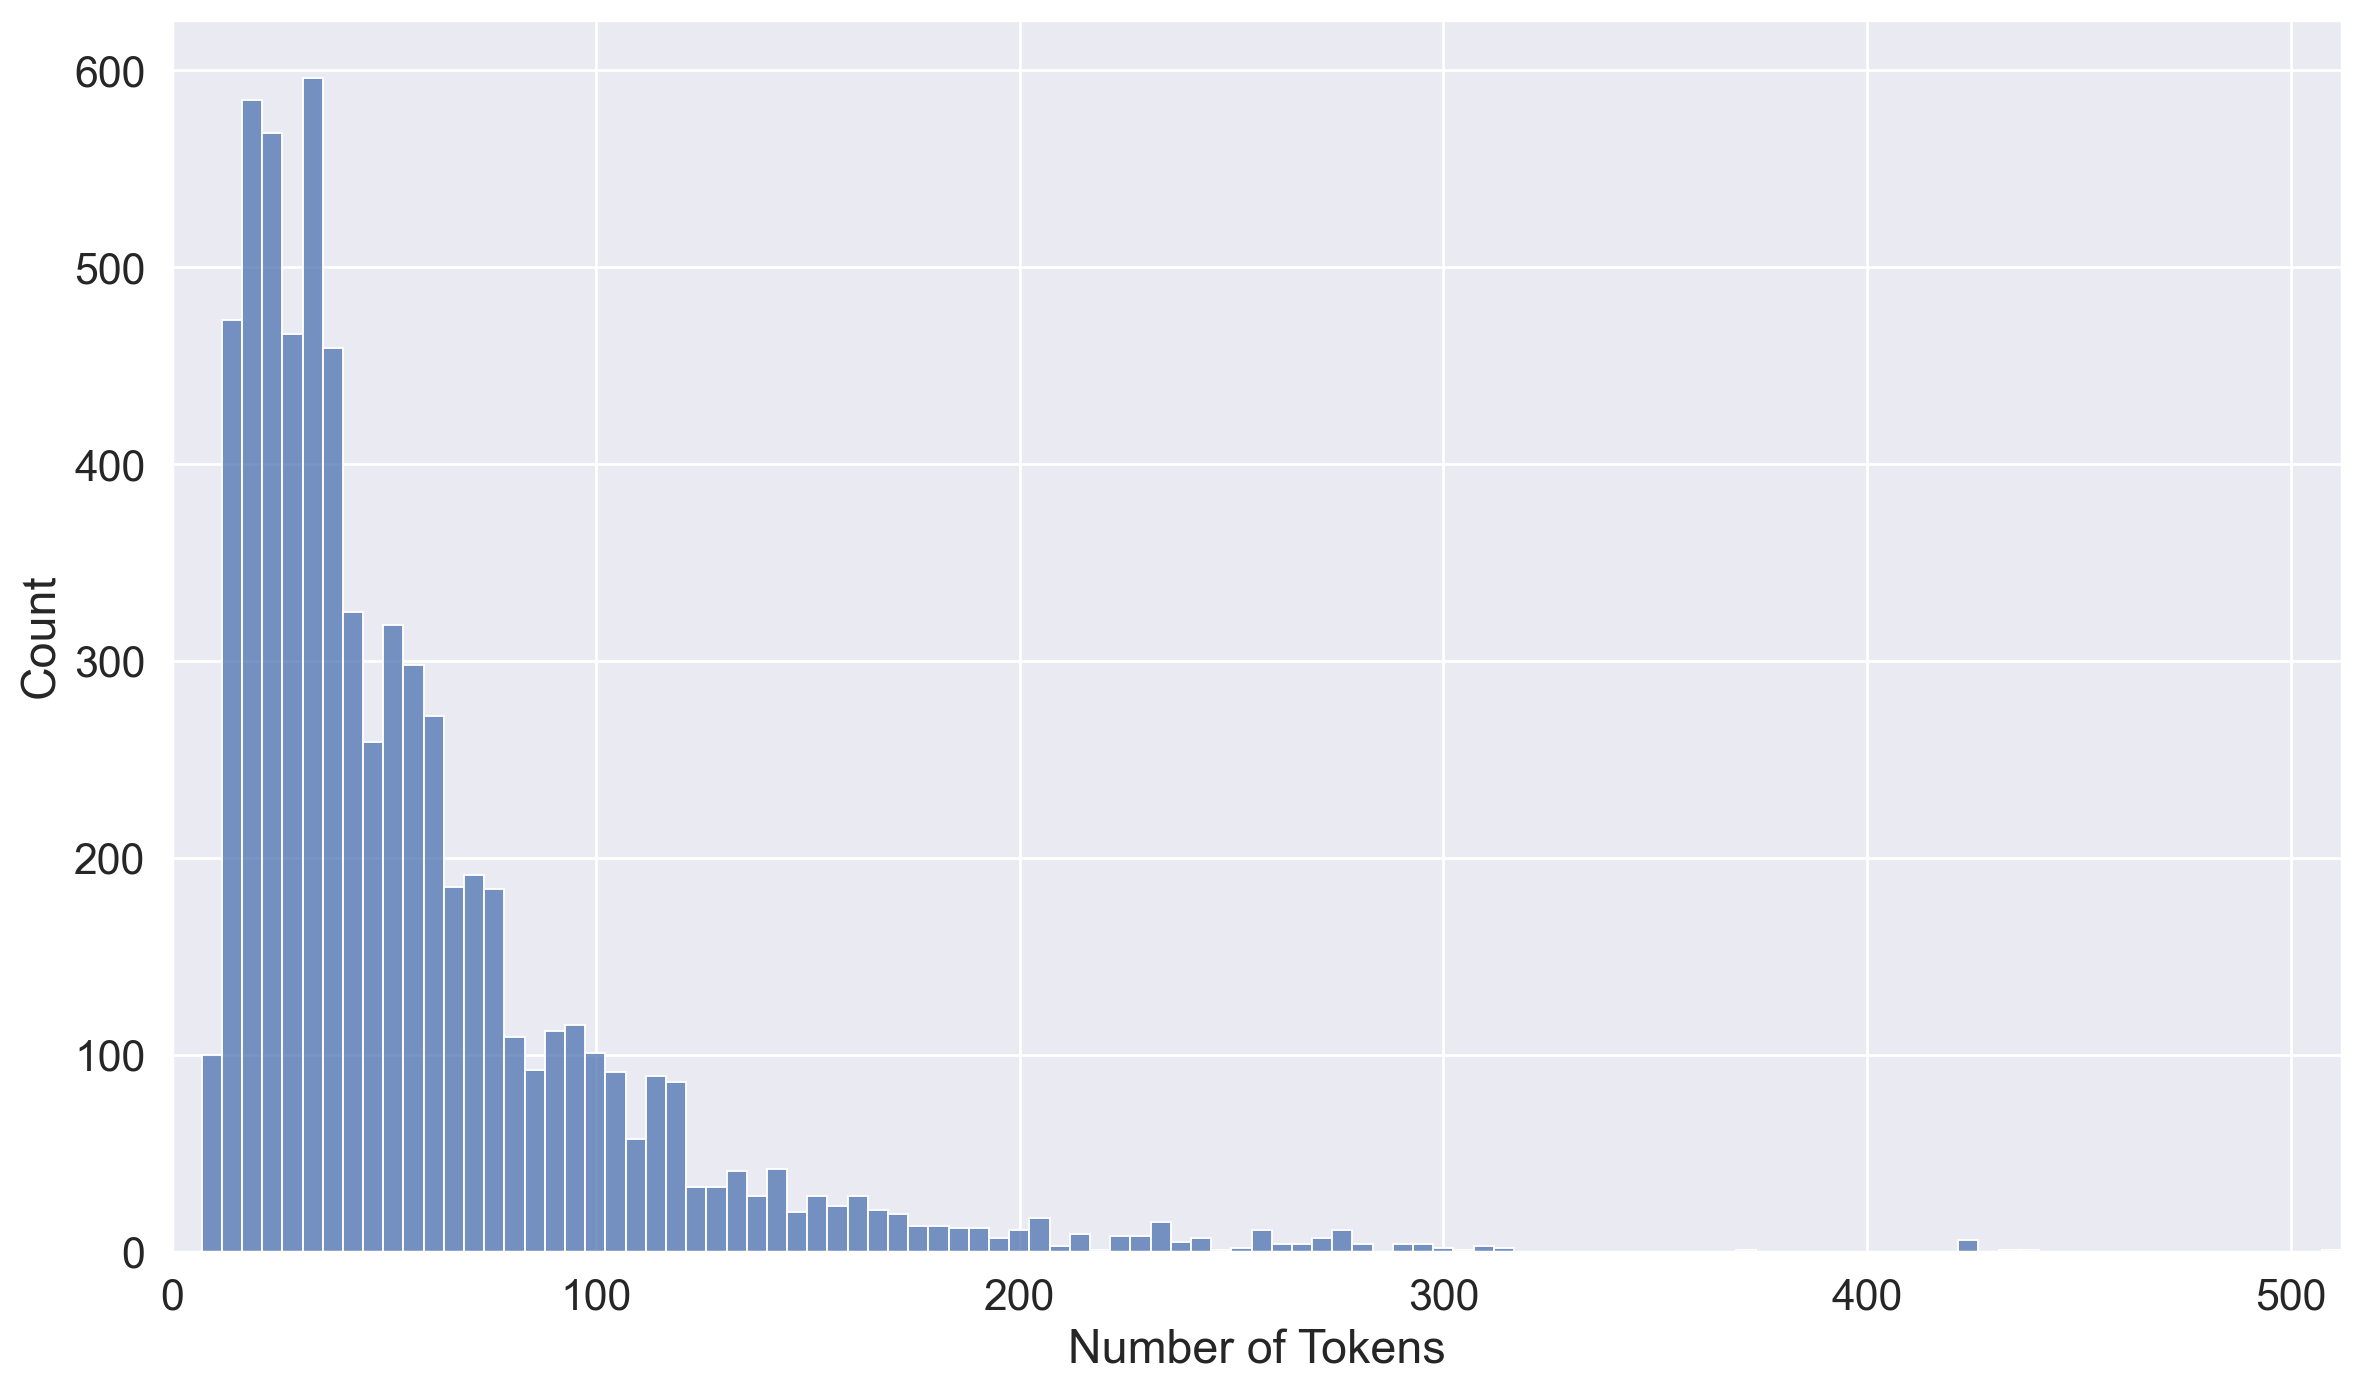

In [129]:
token_lens = []

for txt in df.cleaned_reviews:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (14,8)
sns.histplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Number of Tokens')
plt.show()

In [131]:
#Deciding max length based on the lengths
MAX_SEQ_LENGTH = 260

In [132]:
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_reviews'],df.sentiment, test_size=0.3, random_state = 42, stratify=df.sentiment)

In [133]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42, stratify= y_test)

In [134]:
# Create TensorDatasets
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

In [135]:
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(test_reviews))]



In [136]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.
 
# Padding value: is optional, the default is 0.

# Train dataset
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

# Validation dataset
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

# Test dataset
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long", 
                          value=0, truncating="post", padding="post")

In [137]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in test_input_ids]

In [138]:
# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

In [139]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [140]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

2

In [141]:
from transformers import logging
logging.set_verbosity_error()

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # The 12-layer BERT model with an uncased vocab
    num_labels = 2, # For binary classification  
    output_attentions = False, # Not to return attentions weights
    output_hidden_states = False, # Not to return all hidden-states
)

In [142]:
model = model.to(device) 

In [143]:
epochs=2

optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Create the learning rate scheduler
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function and move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

In [144]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

In [146]:
from tqdm import tqdm
import time

# Assuming you have already imported the necessary libraries and defined your model, dataloaders, etc.

# Store for each epoch
loss_train_values = []
acc_train_values = []
loss_val_values = []
acc_val_values = []

# Training loop
for epoch in range(epochs):
    # --- Train ---

    # Perform forward pass over the training dataset
    print("\n Epoch {:}/{:} :".format(epoch + 1, epochs))
    print('Training....')

    # Measure how long the training epoch takes
    t0 = time.time()
    # Reset total loss and accuracy for this epoch
    total_loss = 0
    total_acc = 0

    # Put the model in training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
        # Update progress for each 100 steps
        if (step % 100 == 0) and (not step == 0):
            # Calculate elapsed time in minutes
            elapsed = format_time((time.time() - t0))
            # Report progress
            print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack training batch from trainloader and move to GPU
        b_input_ids = batch[0].to(device)  # 0 - input ids tensor
        b_attention_mask = batch[1].to(device)  # 1 - input masks tensor
        b_labels = batch[2].long().to(device)  # Convert to torch.long

        # Clear any previously calculated gradients in PyTorch before performing a backward pass
        model.zero_grad()

        # Output the results
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)  # Return tuple
        # Loss value from output
        loss = outputs.loss  # Loss

        # Update total loss
        total_loss += loss.item()

        preds = outputs.logits  # Output probabilities
        # Move logits and labels to CPU
        preds = preds.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        tmp_train_accuracy = accuracy(preds, label_ids)

        # Accumulate the total accuracy
        total_acc += tmp_train_accuracy

        # Perform a backward pass to calculate gradients
        loss.backward()

        # To avoid exploding vanishing gradients problem, clip the norm of the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the parameters (weights)
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over training data
    avg_total_loss = total_loss / len(train_dataloader)

    # Store the loss values
    loss_train_values.append(avg_total_loss)

    # Calculate the average accuracy over the training data
    avg_train_acc = total_acc / len(train_dataloader)

    # Store the accuracy values
    acc_train_values.append(avg_train_acc)

    print("")
    print("\nAverage training accuracy: {0:.2f}".format(avg_train_acc))

    print('Average training loss : {0:.2f}'.format(avg_total_loss))
    print('Training epoch took: {:}'.format(format_time(time.time() - t0)))

    # --- VALIDATION ---

    # After each epoch perform validation to check model performance
    print('\n Running validation...')

    t0 = time.time()
    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Unpack validation batch from trainloader and move to GPU
    for batch in tqdm(val_dataloader, desc='Validation'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)  # Convert to torch.long

        # Tell model not to compute gradients to save memory and accelerate validation
        with torch.no_grad():
            # Forward pass, calculate logit prediction
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        # Update total evaluation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch and accumulate it over all batches
        total_eval_accuracy += accuracy(logits, label_ids)

    # Compute the average accuracy over all of the batches
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)

    # Store the accuracy values
    acc_val_values.append(avg_val_accuracy)

    # Compute the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Store the loss values
    loss_val_values.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))



 Epoch 1/2 :
Training....


Epoch 1/2:  34%|███▍      | 100/292 [1:01:33<1:23:42, 26.16s/it]

 Batch   100 of   292. Elapsed:1:01:33.


Epoch 1/2:  68%|██████▊   | 200/292 [1:44:36<45:36, 29.75s/it]  

 Batch   200 of   292. Elapsed:1:44:37.


Epoch 1/2: 100%|██████████| 292/292 [2:25:24<00:00, 29.88s/it]




Average training accuracy: 0.99
Average training loss : 0.06
Training epoch took: 2:25:25

 Running validation...


Validation: 100%|██████████| 63/63 [11:51<00:00, 11.30s/it]


  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:11:52

 Epoch 2/2 :
Training....


Epoch 2/2:  34%|███▍      | 100/292 [45:05<1:38:43, 30.85s/it]

 Batch   100 of   292. Elapsed:0:45:06.


Epoch 2/2:  68%|██████▊   | 200/292 [1:28:24<39:16, 25.61s/it]  

 Batch   200 of   292. Elapsed:1:28:24.


Epoch 2/2: 100%|██████████| 292/292 [2:07:13<00:00, 26.14s/it]




Average training accuracy: 0.99
Average training loss : 0.05
Training epoch took: 2:07:13

 Running validation...


Validation: 100%|██████████| 63/63 [09:37<00:00,  9.17s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:09:38


In [148]:
import os

model_save_path = 'Saved_models/sentiment_model.pth'
os.makedirs('Saved_models/', exist_ok=True)  # Create the directory if it doesn't exist
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to Saved_models/sentiment_model.pth


In [150]:
import pickle

# Assuming you have the lists you want to save: loss_train_values, acc_train_values, loss_val_values, acc_val_values

# Save the lists to a file
with open('Saved_models/training_metrics.pkl', 'wb') as f:
    pickle.dump({
        'loss_train_values': loss_train_values,
        'acc_train_values': acc_train_values,
        'loss_val_values': loss_val_values,
        'acc_val_values': acc_val_values
    }, f)

In [151]:
# Load the lists from the file
with open('Saved_models/training_metrics.pkl', 'rb') as f:
    loaded_metrics = pickle.load(f)

# Access the loaded lists
loaded_loss_train_values = loaded_metrics['loss_train_values']
loaded_acc_train_values = loaded_metrics['acc_train_values']
loaded_loss_val_values = loaded_metrics['loss_val_values']
loaded_acc_val_values = loaded_metrics['acc_val_values']

In [153]:
model_save_path = 'Saved_models/sentiment_model.pth'  
model.load_state_dict(torch.load(model_save_path))

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [154]:
df_acc = pd.DataFrame(acc_val_values,columns=['Accuracy'])
df_acc.index+=1

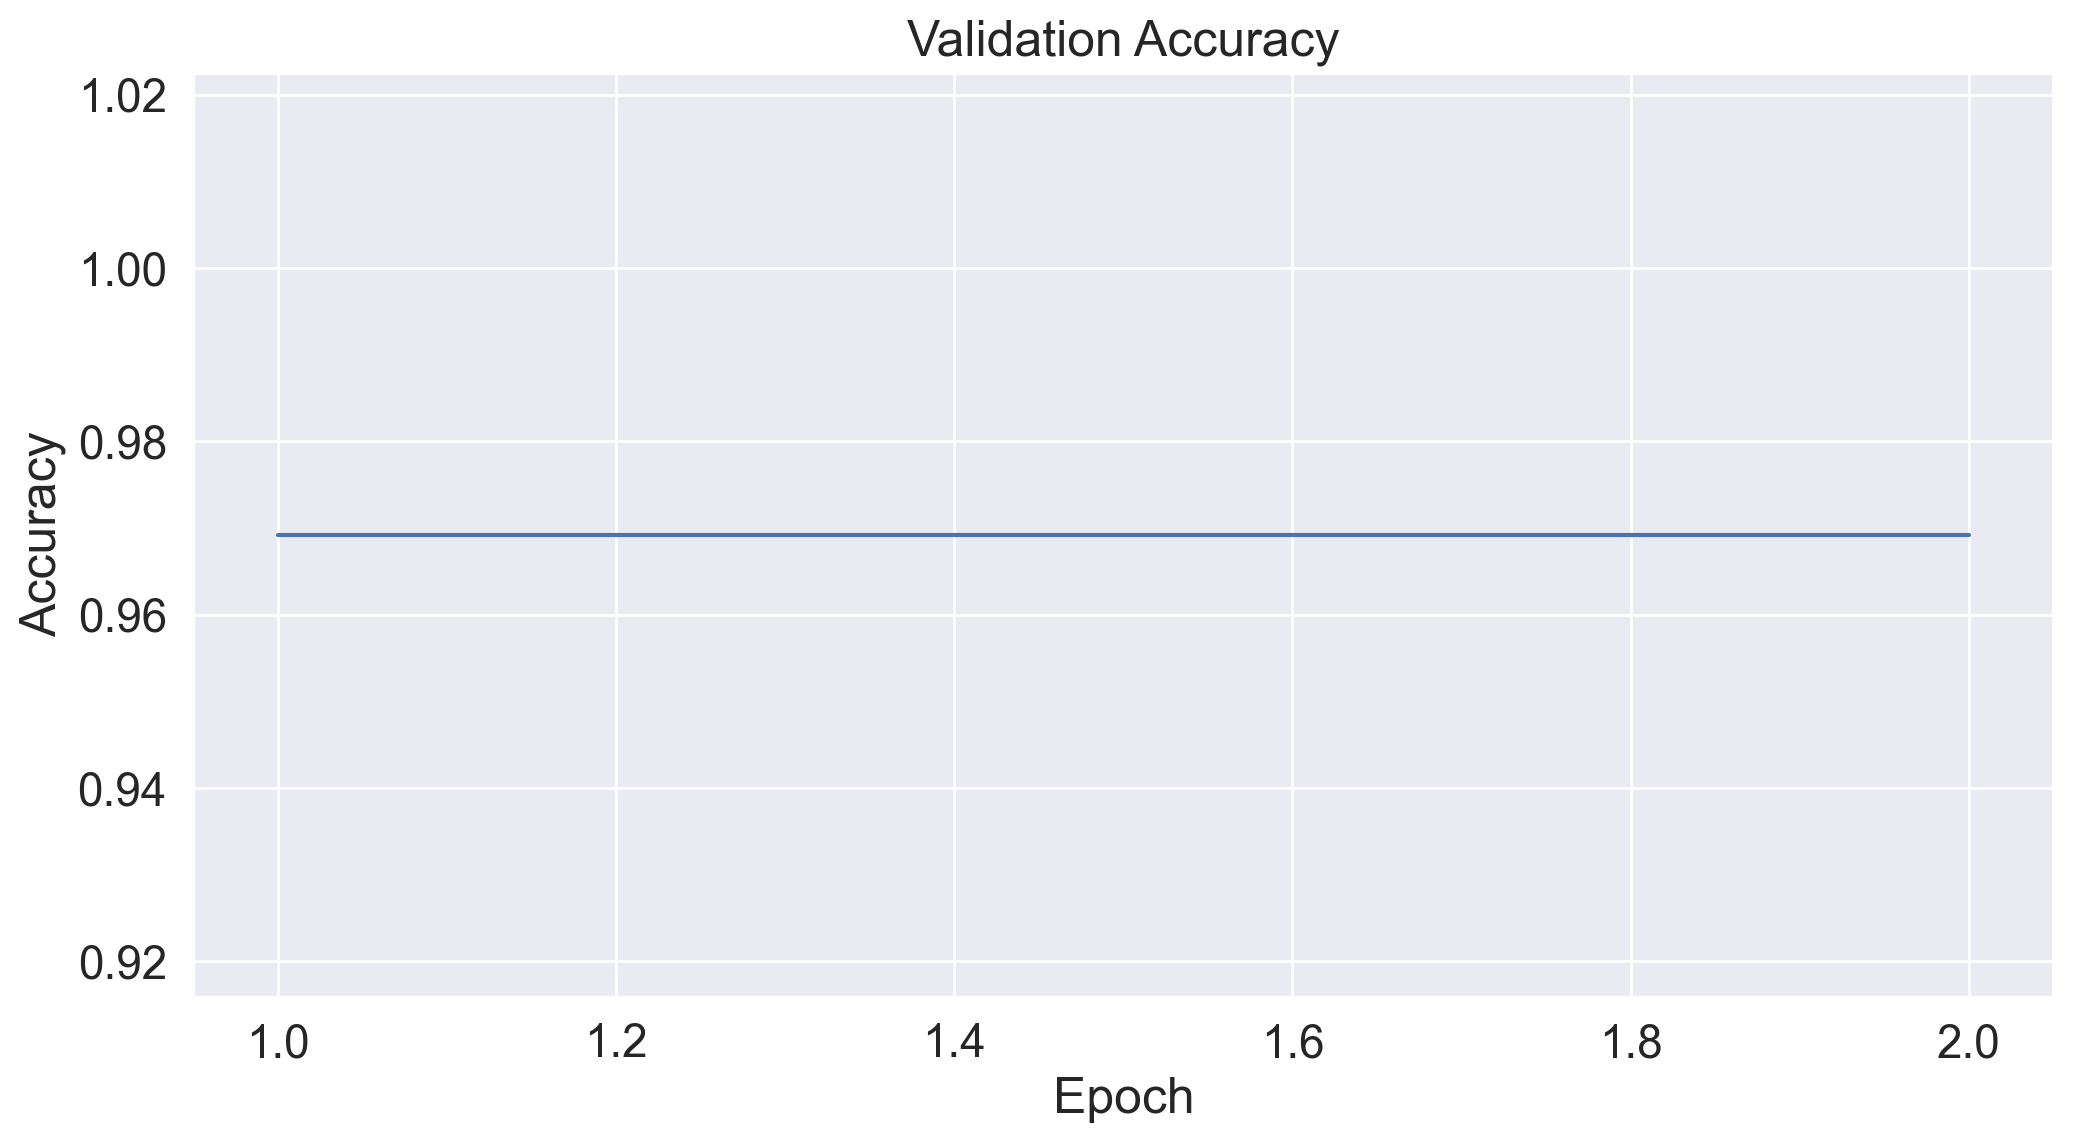

In [155]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_acc,x=df_acc.index,y=df_acc.Accuracy)

# Label the plot
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()


In [156]:

df_loss = pd.DataFrame(loss_val_values,columns=['Loss'])
df_loss.index+=1

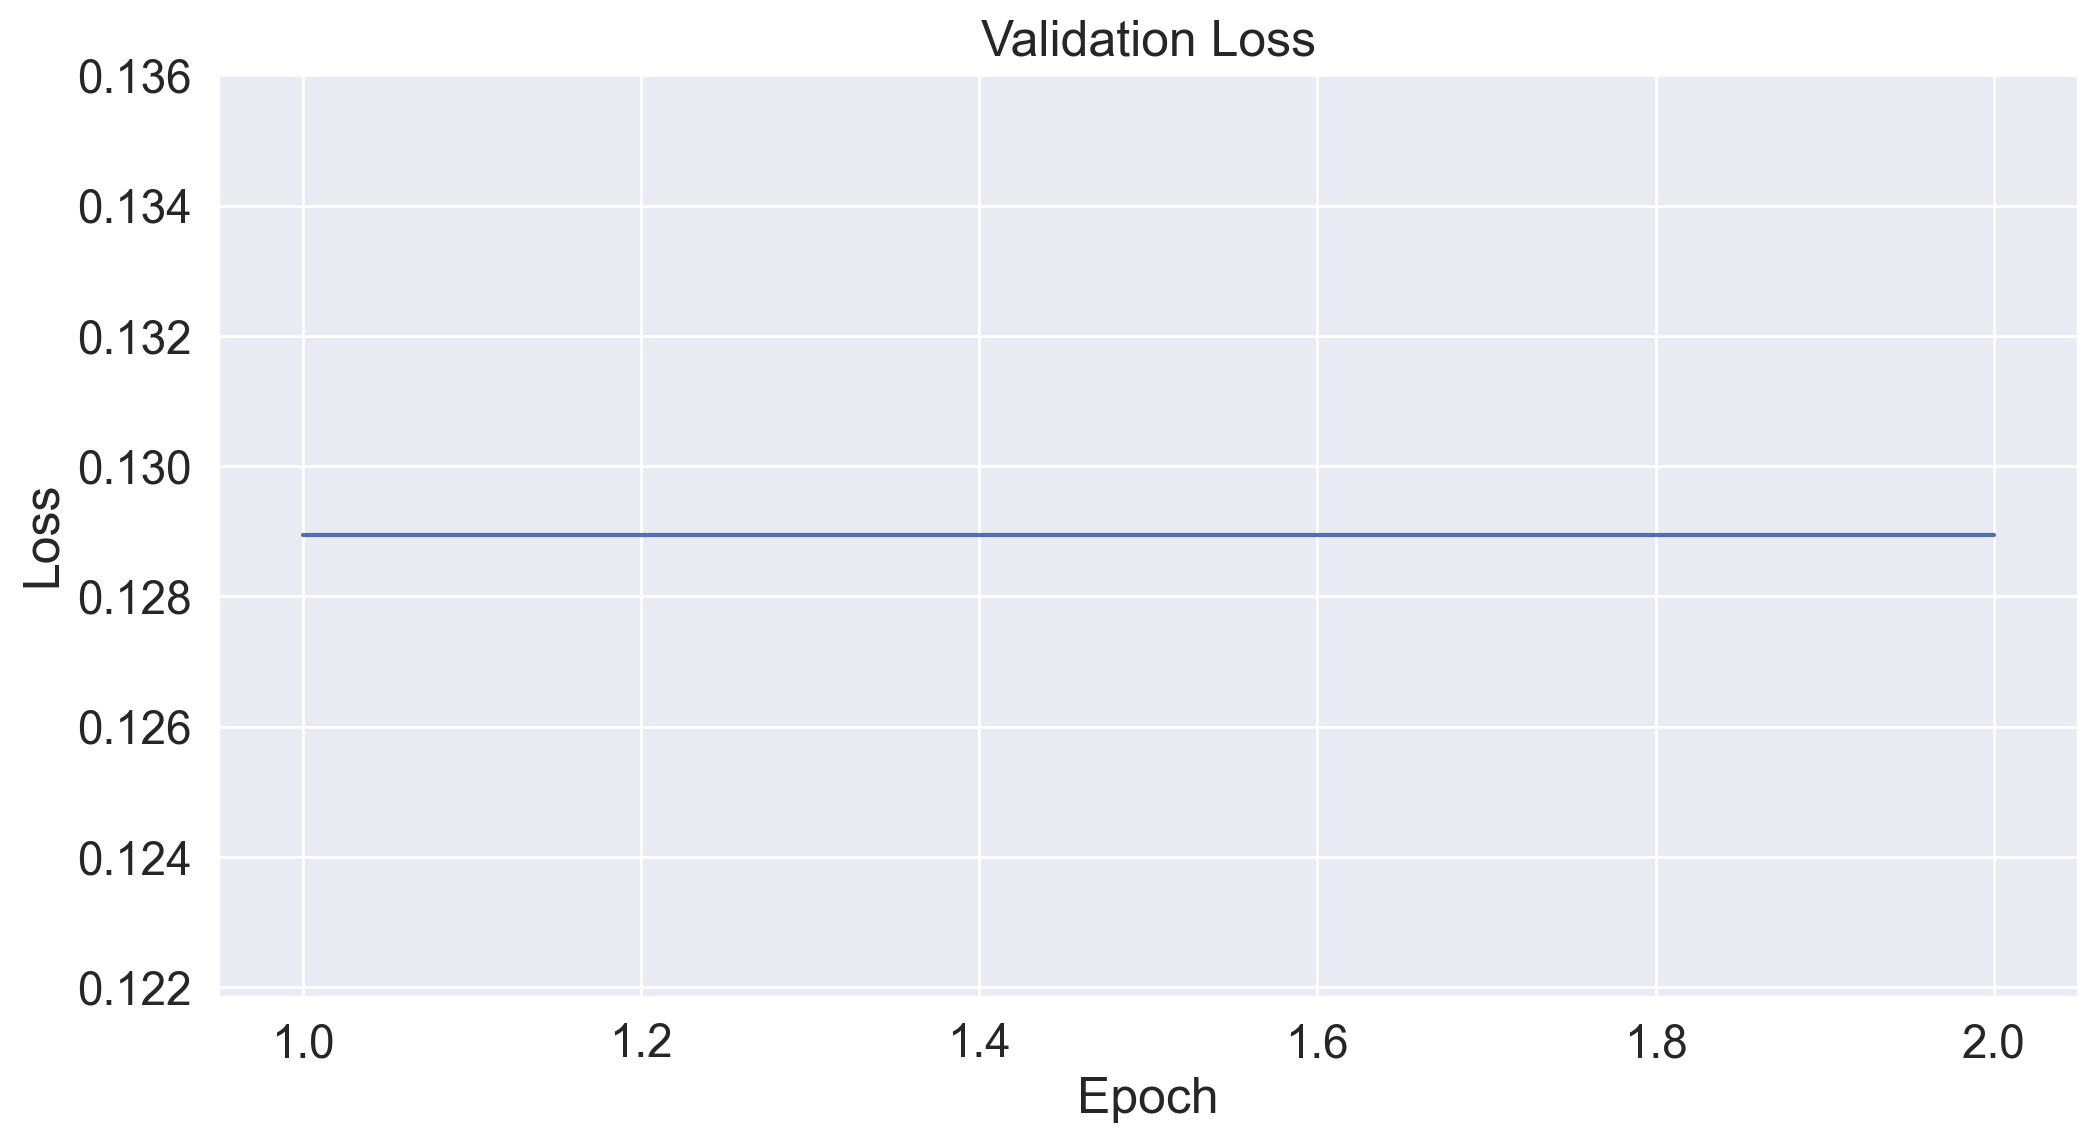

In [157]:


# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
sns.lineplot(data=df_loss,x=df_loss.index,y=df_loss.Loss)

# Label the plot
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()



In [159]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Create a tqdm progress bar for the test dataloader
for batch in tqdm(test_dataloader, desc='Predicting', leave=False):
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids, b_attention_mask, b_labels = batch
    # Tell model not to compute gradients to save memory and accelerate validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
    # logits are class probabilities and get them from outputs
    logits = outputs[0]

    # Store predictions and true labels
    predictions.extend(logits.tolist())
    true_labels.extend(b_labels.tolist())

print('Predictions Done')


Predictions Done


In [160]:


import torch.nn.functional as F
preds = torch.tensor(predictions)

preds = F.softmax(preds,dim=1)


preds = np.array(preds)
true_labels = np.array(true_labels)



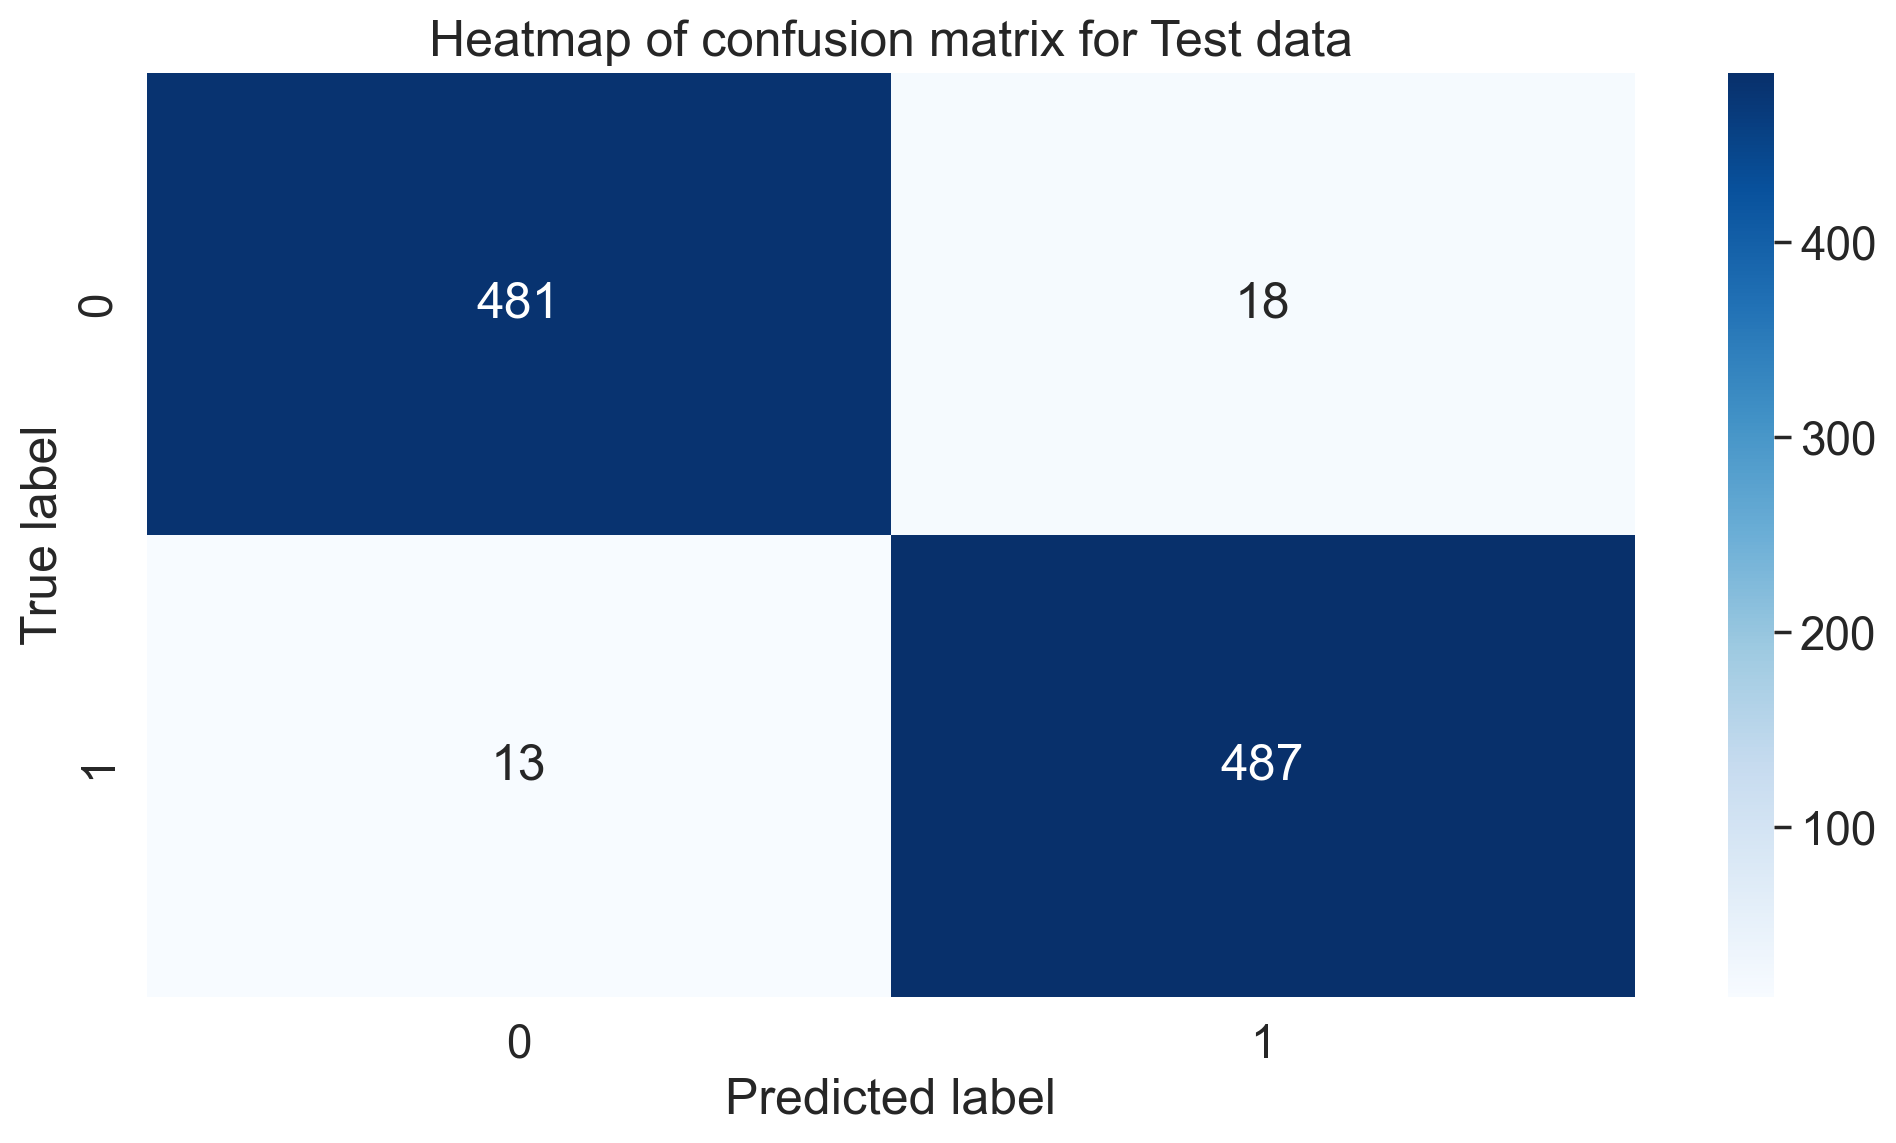

In [161]:


def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(true_labels, preds.argmax(1))
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
evaluate(true_labels, preds.argmax(1))



In [162]:


class_report= classification_report(true_labels, preds.argmax(1), digits=3)
print(class_report)



              precision    recall  f1-score   support

           0      0.974     0.964     0.969       499
           1      0.964     0.974     0.969       500

    accuracy                          0.969       999
   macro avg      0.969     0.969     0.969       999
weighted avg      0.969     0.969     0.969       999
